In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv
from textblob import TextBlob
import sklearn
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold, cross_val_score, train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.learning_curve import learning_curve
import nltk

/home/kamil/miniconda3/envs/venv/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/kamil/miniconda3/envs/venv/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/home/kamil/miniconda3/envs/venv/lib/python3.5/site-packages/sklearn/learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This 

In [2]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

Populating the interactive namespace from numpy and matplotlib


In [3]:
import pandas as pd

In [4]:
import pickle

train = pickle.load( open( "TwitterLID-groundtruth/langid.train", "rb" ) )
test = pickle.load( open( "TwitterLID-groundtruth/langid.test", "rb" ) )

twtrain = pd.DataFrame()
twtrain['text'] = train[0]
twtrain['lang'] = train[1]

twtest = pd.DataFrame()
twtest['text'] = test[0]
twtest['lang'] = test[1]

In [5]:
from nltk import ngrams
def split_into_tokens(message):
    return message.split()
def split_into_bigram_tokens(message):
    res = []
    res += [x for x in ngrams(message.split(),2)]
    return res
def split_into_bigrams(message):
    res = []
    for word in message.split():
        res+=[''.join(x) for x in [x for x in ngrams(word, 2)]]
    return res
def split_into_trigrams(message):
    res = []
    for word in message.split():
        res+=[''.join(x) for x in [x for x in ngrams(word, 3)]]
    return res
def split_into_fourgrams(message):
    res = []
    for word in message.split():
        res+=[''.join(x) for x in [x for x in ngrams(word, 2)]]
    return res

import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets

from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting normalize=True.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')



    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '{:.2f}'.format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Baseline model
Multinomial Naive bayes classifier. Features: words

In [7]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=split_into_tokens)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('nb', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

parameters = {
    'nb__alpha':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
}
X_train, X_test, y_train, y_test = twtrain['text'], twtest['text'], twtrain['lang'], twtest['lang']
print("Train data size: %d" % len(X_train))
clf = GridSearchCV(pipeline, parameters, cv=3, n_jobs=-1)
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()

print("Best score: %0.3f" % clf.best_score_)

Train data size: 1389
Best parameters set found on development set:

{'nb__alpha': 0.1}

Best score: 0.910


Normalized confusion matrix


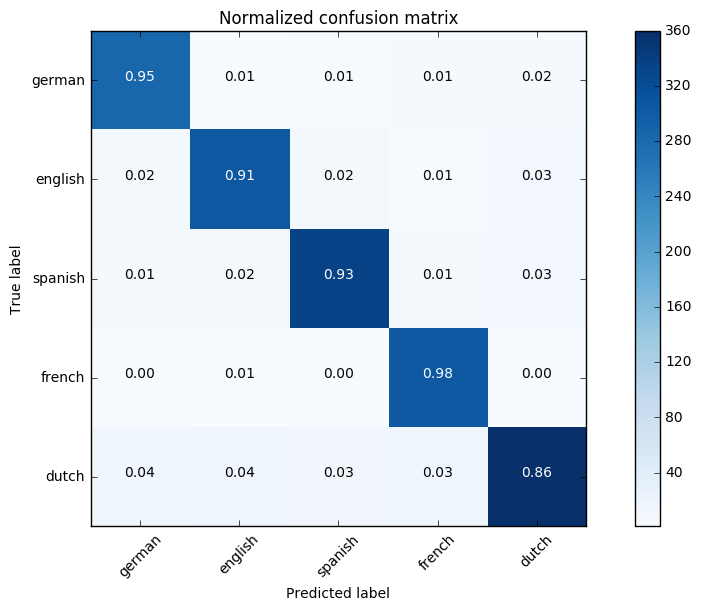

In [8]:
# Compute confusion matrix
y_pred = clf.predict(X_test)
cnf_matrix = confusion_matrix(y_pred, y_test)
np.set_printoptions(precision=3)

# Plot normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=twtrain.lang.unique(), normalize=True,
                      title='Normalized confusion matrix')
fig = plt.Figure()
fig.set_canvas(plt.gcf().canvas)
# fig.savefig('{}{}{}gram_cm_{}.pdf'.format(stops,mode,ngrams, classif), format='pdf')

In [9]:
print(sklearn.metrics.classification_report(y_test, y_pred, target_names=twtest.lang.unique(), digits=3))

             precision    recall  f1-score   support

     german      0.953     0.911     0.931       313
    english      0.913     0.910     0.912       334
    spanish      0.925     0.930     0.928       359
     french      0.984     0.924     0.953       328
      dutch      0.859     0.933     0.894       386

avg / total      0.924     0.922     0.923      1720



# Naive bayes. Features: character bigrams

In [11]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=split_into_bigrams)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('nb', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

parameters = {
    'nb__alpha':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
}
X_train, X_test, y_train, y_test = twtrain['text'], twtest['text'], twtrain['lang'], twtest['lang']
print("Train data size: %d" % len(X_train))
clf = GridSearchCV(pipeline, parameters, cv=3, n_jobs=-1)
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()

print("Best score: %0.3f" % clf.best_score_)

Train data size: 1389
Best parameters set found on development set:

{'nb__alpha': 0.6}

Best score: 0.871


In [12]:
y_pred = clf.predict(X_test)
print(sklearn.metrics.classification_report(y_test, y_pred, target_names=twtest.lang.unique(), digits=3))

             precision    recall  f1-score   support

     german      0.901     0.869     0.885       313
    english      0.845     0.847     0.846       334
    spanish      0.890     0.852     0.871       359
     french      0.895     0.933     0.913       328
      dutch      0.866     0.891     0.879       386

avg / total      0.879     0.878     0.878      1720



# Naive Bayes. Features: character trigrams

In [14]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=split_into_trigrams)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('nb', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

parameters = {
    'nb__alpha':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
}
X_train, X_test, y_train, y_test = twtrain['text'], twtest['text'], twtrain['lang'], twtest['lang']
print("Train data size: %d" % len(X_train))
clf = GridSearchCV(pipeline, parameters, cv=3, n_jobs=-1)
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()

print("Best score: %0.3f" % clf.best_score_)

Train data size: 1389
Best parameters set found on development set:

{'nb__alpha': 0.2}

Best score: 0.899


In [15]:
y_pred = clf.predict(X_test)
print(sklearn.metrics.classification_report(y_test, y_pred, target_names=twtest.lang.unique(), digits=3))

             precision    recall  f1-score   support

     german      0.948     0.923     0.935       313
    english      0.877     0.871     0.874       334
    spanish      0.890     0.880     0.885       359
     french      0.947     0.973     0.959       328
      dutch      0.908     0.920     0.914       386

avg / total      0.913     0.913     0.913      1720



# Naive Bayes. Features: 4grams

In [16]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=split_into_fourgrams)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('nb', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

parameters = {
    'nb__alpha':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
}
X_train, X_test, y_train, y_test = twtrain['text'], twtest['text'], twtrain['lang'], twtest['lang']
print("Train data size: %d" % len(X_train))
clf = GridSearchCV(pipeline, parameters, cv=3, n_jobs=10, verbose=1)
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()

print("Best score: %0.3f" % clf.best_score_)

Train data size: 1389
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=10)]: Done  30 out of  30 | elapsed:    0.7s finished


Best parameters set found on development set:

{'nb__alpha': 0.6}

Best score: 0.871


In [17]:
y_pred = clf.predict(X_test)
print(sklearn.metrics.classification_report(y_test, y_pred, target_names=twtest.lang.unique(), digits=3))

             precision    recall  f1-score   support

     german      0.901     0.869     0.885       313
    english      0.845     0.847     0.846       334
    spanish      0.890     0.852     0.871       359
     french      0.895     0.933     0.913       328
      dutch      0.866     0.891     0.879       386

avg / total      0.879     0.878     0.878      1720



# Naive bayes with word bigrams

In [18]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=split_into_bigram_tokens)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('nb', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

parameters = {
    'nb__alpha':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
}
X_train, X_test, y_train, y_test = twtrain['text'], twtest['text'], twtrain['lang'], twtest['lang']
print("Train data size: %d" % len(X_train))
clf = GridSearchCV(pipeline, parameters, cv=3, n_jobs=10, verbose=1)
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()

print("Best score: %0.3f" % clf.best_score_)

Train data size: 1389
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=10)]: Done  11 out of  30 | elapsed:    0.2s remaining:    0.4s


Best parameters set found on development set:

{'nb__alpha': 0.1}

Best score: 0.462


[Parallel(n_jobs=10)]: Done  30 out of  30 | elapsed:    0.5s finished


In [19]:
y_pred = clf.predict(X_test)
print(sklearn.metrics.classification_report(y_test, y_pred, target_names=twtest.lang.unique(), digits=3))

             precision    recall  f1-score   support

     german      0.988     0.524     0.685       313
    english      0.943     0.398     0.560       334
    spanish      0.977     0.476     0.640       359
     french      0.980     0.299     0.458       328
      dutch      0.333     0.982     0.497       386

avg / total      0.829     0.549     0.566      1720



# SVM

In [20]:
%%time
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=split_into_tokens)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('svc', SVC()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

parameters = [{'svc__kernel': ['rbf'], 'svc__gamma': [1e-2, 1e-3, 1e-4],'svc__C': [1, 10, 100, 1000]},
    {'svc__kernel': ['linear'], 'svc__C': [1, 10, 100, 1000]}]

X_train, X_test, y_train, y_test = twtrain['text'], twtest['text'], twtrain['lang'], twtest['lang']
print("Train data size: %d" % len(X_train))
clf = GridSearchCV(pipeline, parameters, cv=3, n_jobs=-1)
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
res = None
cur_max = -1
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    if mean > cur_max:
        cur_max = mean
        res = "%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params)
print(res)

Train data size: 1389
Best parameters set found on development set:

{'svc__gamma': 0.01, 'svc__C': 100, 'svc__kernel': 'rbf'}

Grid scores on development set:

0.886 (+/-0.038) for {'svc__gamma': 0.01, 'svc__C': 100, 'svc__kernel': 'rbf'}
CPU times: user 920 ms, sys: 412 ms, total: 1.33 s
Wall time: 2.2 s


Normalized confusion matrix


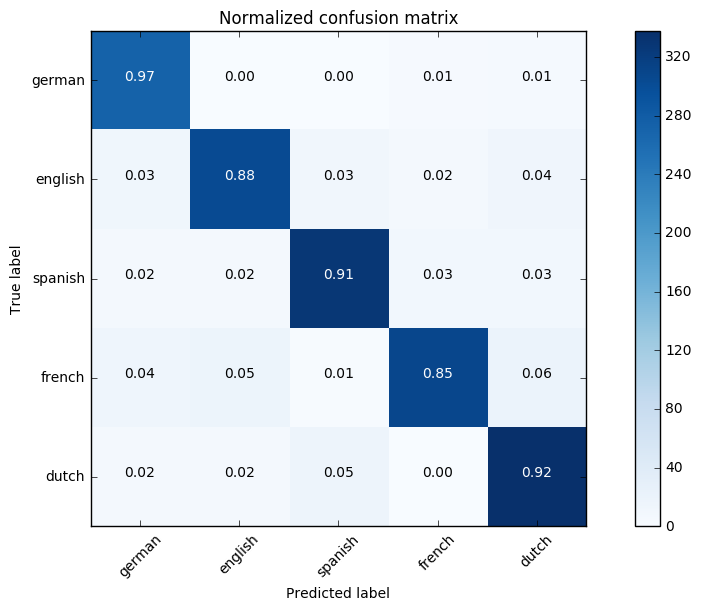

In [21]:
# Compute confusion matrix
y_pred = clf.predict(X_test)
cnf_matrix = confusion_matrix(y_pred, y_test)
np.set_printoptions(precision=3)

# Plot normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=twtrain.lang.unique(), normalize=True,
                      title='Normalized confusion matrix')
fig = plt.Figure()
fig.set_canvas(plt.gcf().canvas)
# fig.savefig('{}{}{}gram_cm_{}.pdf'.format(stops,mode,ngrams, classif), format='pdf')

In [22]:
y_pred = clf.predict(X_test)
print(sklearn.metrics.classification_report(y_test, y_pred, target_names=twtest.lang.unique(), digits=3))

             precision    recall  f1-score   support

     german      0.972     0.872     0.919       313
    english      0.876     0.907     0.891       334
    spanish      0.909     0.914     0.911       359
     french      0.848     0.939     0.891       328
      dutch      0.916     0.876     0.895       386

avg / total      0.904     0.901     0.901      1720



# Ada boost

In [23]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=split_into_tokens)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('ada', AdaBoostClassifier()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

parameters = {
    'ada__base_estimator': [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=2), DecisionTreeClassifier(max_depth=3)],
    'ada__algorithm': ['SAMME.R','SAMME'],
    'ada__n_estimators': [300]
}
X_train, X_test, y_train, y_test = twtrain['text'], twtest['text'], twtrain['lang'], twtest['lang']
print("Train data size: %d" % len(X_train))
clf = GridSearchCV(pipeline, parameters, cv=3, n_jobs=-1)
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
res = None
cur_max = -1
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    if mean > cur_max:
        cur_max = mean
        res = "%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params)
print(res)

Train data size: 1389
Best parameters set found on development set:

{'ada__n_estimators': 300, 'ada__algorithm': 'SAMME', 'ada__base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')}

Grid scores on development set:

0.765 (+/-0.051) for {'ada__n_estimators': 300, 'ada__algorithm': 'SAMME', 'ada__base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')}


In [24]:
y_pred = clf.predict(X_test)
print(sklearn.metrics.classification_report(y_test, y_pred, target_names=twtest.lang.unique(), digits=3))

             precision    recall  f1-score   support

     german      0.991     0.738     0.846       313
    english      0.559     0.937     0.700       334
    spanish      0.923     0.738     0.820       359
     french      0.953     0.741     0.834       328
      dutch      0.795     0.793     0.794       386

avg / total      0.842     0.790     0.798      1720



# Recursive feature elimination

In [25]:
bow_transformer = CountVectorizer(analyzer=split_into_tokens).fit(twtrain['text'])
print(len(bow_transformer.vocabulary_))

10344


In [26]:
list(bow_transformer.vocabulary_)[:10]

['melden!!!',
 'Euch',
 'am',
 'Aktive',
 'Enjoy',
 '#Stadt',
 'cabeza',
 'brng',
 '#drogerie',
 'Opera']

In [27]:
messages_bow = bow_transformer.transform(twtrain['text'])
test_bow = bow_transformer.transform(twtest['text'])
print('sparse matrix shape:', messages_bow.shape)
print('number of non-zeros:', messages_bow.nnz)
print('sparsity: %.2f%%' % (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1])))

sparse matrix shape: (1389, 10344)
number of non-zeros: 17411
sparsity: 0.12%


In [28]:
%%time
tfidf_transformer = TfidfTransformer().fit(messages_bow)

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 2.48 ms


In [29]:
tfidf4 = tfidf_transformer.transform(messages_bow)
X_test=tfidf_transformer.transform(test_bow)

In [30]:
from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(tfidf4, twtrain['lang'], test_size=0.33, random_state=42)
X_train, X_test, y_train, y_test = tfidf4, X_test, twtrain['lang'], twtest['lang']

In [31]:
from sklearn.feature_selection import RFECV
rfecv = RFECV(estimator=MultinomialNB(alpha=0.2), step=0.05, scoring='accuracy',verbose=1, n_jobs=-1)
rfecv.fit(X_train, y_train)
print("Optimal number of features : %d" % rfecv.n_features_)
print(rfecv.grid_scores_)

Optimal number of features : 10344
[ 0.222  0.222  0.222  0.222  0.222  0.222  0.222  0.254  0.343  0.397
  0.426  0.463  0.477  0.498  0.517  0.544  0.557  0.569  0.59   0.631
  0.711  0.909]


Normalized confusion matrix


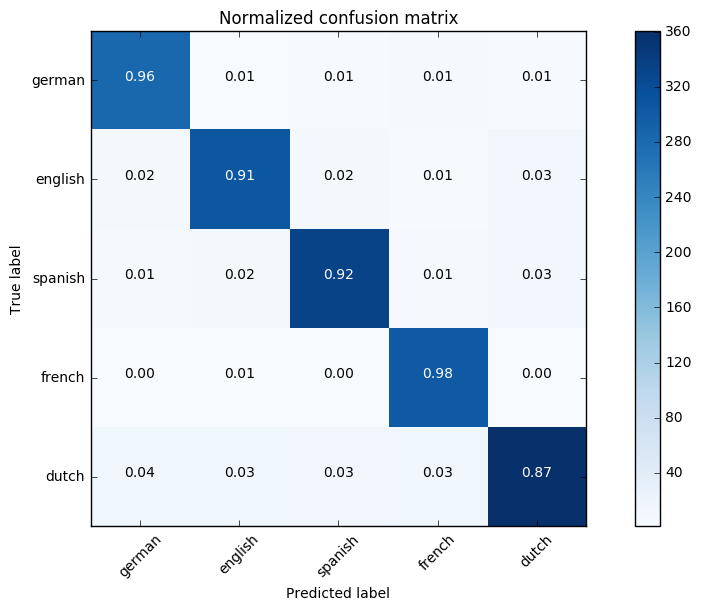

In [32]:
# Compute confusion matrix
y_pred = rfecv.predict(X_test)
cnf_matrix = confusion_matrix(y_pred, y_test)
np.set_printoptions(precision=3)

# Plot normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=twtrain.lang.unique(), normalize=True,
                      title='Normalized confusion matrix')
fig = plt.Figure()
fig.set_canvas(plt.gcf().canvas)
# fig.savefig('{}{}{}gram_cm_{}.pdf'.format(stops,mode,ngrams, classif), format='pdf')

In [33]:
y_pred = rfecv.predict(X_test)
print(sklearn.metrics.classification_report(y_test, y_pred, target_names=twtest.lang.unique(), digits=3))

             precision    recall  f1-score   support

     german      0.960     0.911     0.934       313
    english      0.914     0.919     0.916       334
    spanish      0.923     0.930     0.926       359
     french      0.984     0.924     0.953       328
      dutch      0.866     0.935     0.899       386

avg / total      0.927     0.924     0.925      1720



In [34]:
print(rfecv.score(X_test, y_test))

0.924418604651
